# [Репозиторий](https://github.com/Lynxtail/Additional-chapters-of-fundamental-training)

## Задание G, вариант 1

Выполнить хэширование с помощью $T$-функции $H : \{0, 1\}^m \times \{0, 1\}^m \rightarrow \{0, 1\}^m$. Для построения функции $H$ нужно использовать корректно определенные операции (арифметические, поразрядные логические, экспоненцирование, деление).

In [2]:
import bitstring as bs
import matplotlib.pyplot as plt
import random

### Определение операций

In [3]:
# наложение маски a and C
def mask_(a:bs.BitArray, C:bs.BitArray='0b1111') -> bs.BitArray:
    return a & C

In [4]:
# экспоненцирование x |^ y := (1 + 2x)^y
def expo_(x:int, y:int, m:int) -> int:
    return pow(1 + 2 * x, y, 2**m)

In [5]:
# деление x/y := x(y |^ (-1)) = x / (1 + 2y)
def divide_(x:int, y:int, m:int) -> int:
    return x * expo_(y, -1, m)

In [6]:
# редуцирование a mod 2^n
def reduce_(a:int, n:int) -> int:
    return a % 2**n

### Вспомогательные функции

Построение $T-$ функции $H:\{0, 1\}^m \times \{0,1\}^m \rightarrow \{0,1\}^m$

Пример такой функции: $$(x \oplus y) + (1 + x^2)$$

In [7]:
# H - T-функция на {0, 1}^m, где m - длина
def H_1(x:bs.BitArray, y:bs.BitArray, m:int) -> bs.BitArray:
    # e.g.
    ans = bs.BitArray(bin((x ^ y).u + (1 + pow(x.u, 2, 2**m))))
    if len(ans) > m:
        ans.overwrite('0b' + ''.join(['0' for _ in range(len(ans) - m)]), 0)
    ans = bs.BitArray(uint=ans.u, length=m)
    return ans

Собственная функция: $$(x \& y)^{x \oplus y} + (x^4 \cdot y \uparrow x)$$

In [8]:
# H - T-функция на {0, 1}^m, где m - длина
def H_2(x:bs.BitArray, y:bs.BitArray, m:int) -> bs.BitArray:
    ans = bs.BitArray(bin(pow((x & y).u, (x ^ y).u, 2**m) + (pow(x.u, 4, 2**m) * expo_(x.u, y.u, m))))
    if len(ans) > m:
        ans.overwrite('0b' + ''.join(['0' for _ in range(len(ans) - m)]), 0)
    ans = bs.BitArray(uint=ans.u, length=m)
    return ans

Разбиение сообщения W на блоки битов длиной $m$

In [9]:
# разбиение сообщения w на блоки a_i длины m каждый
# w = [a_k]...[a_2][a_1]
def split_w(m:int, w:str) -> bs.BitArray:

    # если сообщение не в виде бинарной строки
    if len(set(w).difference({'0', '1'})) != 0:
        a = '.'.join(map(bin, bytearray(w, 'utf8')))[2:].replace('.0b', '')
    # если сообщение в виде бинарной строки
    else: a = w

    # разбиение
    a = [a[max(i - m, 0) : i] for i in range(len(a), 0, -m)]

    # добавление незначащих нулей к крайнему a
    if len(a[-1]) < m:
        a[-1] = ''.join(['0']*(m - len(a[-1]))) + a[-1]

    for i in range(len(a)):
        a[i] = bs.BitArray(bin=a[i])

    print('a = { ', end='')
    [print(f'[{item.b}]', end=' ') for item in a]
    print('}')

    return a

Генерация $h_0$ и вычисление значений функции $H(x, y)$:

In [19]:
def calculate_h(w:str, m:int, a:bs.BitArray, fun:str) -> bs.BitArray:
    # h_{i+1} = H(a_{i+1}, h_i), i = 0, 1, ...
    # h_k - хеш-значение сообщения

    h_0 = [random.randint(0, 1) for _ in range(m)]
    h_0 = ''.join(map(str, h_0))
    # h_0 = '010'
    h_0 = bs.BitArray(bin=h_0)

    k = len(a)
    h = [h_0]
    
    print(f'Исходное сообщение:\n{w}')
    print(f'Используемая функция: {fun}')
    print(f'h0 = {h_0.b}')
    for i in range(k):
        print(f'h{i + 1} = H{a[i].b, h[-1].b}', end=' = ')
        if fun == '(x AND y)^{x XOR y} + (x^4 * y |^ x)':
            h.append(H_2(a[i], h[-1], m))
        if fun == '(x XOR y) + (1 + x^2)':
            h.append(H_1(a[i], h[-1], m))
        print(h[-1].b)
    
    return h

In [20]:
def draw(fun:str, m:int) -> None:
    x, y, z = [], [], []
    for i in range(2 ** m):
        for j in range(2 ** m):
            x.append(i / (2 ** m))
            y.append(j / (2 ** m))
            if fun == '(x XOR y) + (1 + x^2)':
                z.append((H_1(bs.BitArray(uint=i, length=m), bs.BitArray(uint=j, length=m), m).u % (2 ** m)) / (2 ** m))
            if fun == '(x AND y)^{x XOR y} + (x^4 * y |^ x)':
                z.append((H_2(bs.BitArray(uint=i, length=m), bs.BitArray(uint=j, length=m), m).u % (2 ** m)) / (2 ** m))

    fig = plt.figure()
    ax = fig.add_subplot(111, title="Проекция", projection='3d')
    ax.scatter(x, y, z, s=.5)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid()
    plt.show()

### Основная часть

Ввод исходного сообщения и длины $m$ блоков разбиения:

In [21]:
# w = input("Введите сообщение: ")
# m = int(input("Введите длину m: "))

In [22]:
# тестовый пример
w = '0011011010111'
m = 3
fun = '(x XOR y) + (1 + x^2)'

a = { [111] [010] [011] [011] [000] }
Исходное сообщение:
0011011010111
Используемая функция: (x XOR y) + (1 + x^2)
h0 = 100
h1 = H('111', '100') = 101
h2 = H('010', '101') = 100
h3 = H('011', '100') = 001
h4 = H('011', '001') = 100
h5 = H('000', '100') = 101


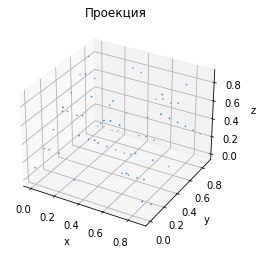

In [23]:
BA_2_uint = lambda x : x.u

a = split_w(m, w)
h = calculate_h(w, m, a, fun)
draw(fun, m)

In [24]:
w = 'Hello World'
m = 10
fun = '(x AND y)^{x XOR y} + (x^4 * y |^ x)'

In [25]:
a = split_w(m, w)
h = calculate_h(w, m, a, fun)
draw(fun, m)

a = { [1001100100] [1100101101] [1111011111] [0000010101] [0011011111] [0110011011] [0110010111] [0000100100] }
Исходное сообщение:
Hello World
Используемая функция: (x AND y)^{x XOR y} + (x^4 * y |^ x)
h0 = 1010100111
h1 = H('1001100100', '1010100111') = 0100000000
h2 = H('1100101101', '0100000000') = 1000010001
h3 = H('1111011111', '1000010001') = 1100100000
h4 = H('0000010101', '1100100000') = 0100110001
h5 = H('0011011111', '0100110001') = 1100100000
h6 = H('0110011011', '1100100000') = 1011110001
h7 = H('0110010111', '1011110001') = 1101110000
h8 = H('0000100100', '1101110000') = 0100000000
